In [1]:
import pandas as pd
import numpy as np
import random
import string
from datetime import datetime, timedelta

from pyspark.sql.functions import coalesce, lit, rand
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegressionModel, RandomForestClassificationModel
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

In [ ]:
packages = [
    'org.apache.hadoop:hadoop-aws:3.3.4',
    'org.apache.hadoop:hadoop-client-api:3.3.4',
    'org.apache.hadoop:hadoop-client-runtime:3.3.4',
]

conf = SparkConf() \
    .setAppName("MyApp") \
    .set("spark.driver.memory", "8g") \
    .set("spark.executor.memory", "8g") \
    .set('spark.jars.packages', ','.join(packages))

sc = SparkContext(conf=conf)

hadoop_config = sc._jsc.hadoopConfiguration()
hadoop_config.set('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
hadoop_config.set('com.amazonaws.services.s3.enableV4', 'true')

spark = SparkSession(sc)

In [49]:
# string label
data = spark.createDataFrame([
    (0, "red",   "SUV",   12, 20.0, 60, "class1", "2024-07-01", "u4pruydqqvj", "Sunday"),
    (1, "red",   "sedan",  9, 30.0, 70, "class2", "2024-07-02", "u4pruydqqvk", "Friday"),
    (2, "red",   "truck", 15, 25.0, 80, "class3", "2024-07-01", "u4pruydqqvj", "Sunday"),
    (3, "blue",  "SUV",   20, 22.0, 65, "class1", "2024-07-02", "u4pruydqqvk", "Monday"),
    (4, "blue",  "sedan",  5, 35.0, 75, "class1", "2024-07-01", "u4pruydqqvj", "Tuesday"),
    (5, "blue",  "truck", 12, 28.0, 85, "class3", "2024-07-02", "u4pruydqqvk", "Tuesday"),
    (6, "green", "SUV",    9, 19.0, 50, "class2", "2024-07-03", "u4pruydqqvl", "Sunday"),
    (7, "green", "sedan", 15, 32.0, 60, "class3", "2024-07-03", "u4pruydqqvm", "Thursday"),
    (8, "green", "truck", 20, 27.0, 40, "class1", "2024-07-04", "u4pruydqqvn", "Saturday"),
    (9, "green", "SUV",    5, 21.0, 55, "class2", "2024-07-04", "u4pruydqqvo", "Saturday")
], ["id", "color", "type", "localHour", "milesperhour", "age", "label", "date", "geohash", "dayOfWeek"])

# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = data.randomSplit([0.8, 0.2])

# String Indexing for features
indexers = [
    StringIndexer(inputCol="label", outputCol="label_index"),
    StringIndexer(inputCol="color", outputCol="color_index"),
    StringIndexer(inputCol="type", outputCol="type_index"),
    StringIndexer(inputCol="localHour", outputCol="localHour_index"),
    StringIndexer(inputCol="dayOfWeek", outputCol="dayOfWeek_index"),
]

# One-Hot Encoding for Logistic Regression (not needed for tree-based models)
encoder = OneHotEncoder(
    inputCols=["color_index", "type_index", "localHour_index", "dayOfWeek_index"],
    outputCols=["color_vec", "type_vec", "localHour_vec", "dayOfWeek_vec"]
)

assembler_lr_nb = VectorAssembler(
    inputCols=["type_vec", "color_vec", "localHour_vec", "milesperhour", "age", "dayOfWeek_vec"],
    outputCol="assembled_features"
)

# Assembling Features for Tree-Based Models
assembler_tree = VectorAssembler(
    inputCols=["color_index", "type_index", "localHour_index", "milesperhour", "age", "dayOfWeek_index"],
    outputCol="features"
)

# MinMaxScaler for Logistic Regression and Naive Bayes
scaler_lr_nb = MinMaxScaler(inputCol="assembled_features", outputCol="features")

# Create and Fit the Pipeline for Logistic Regression and Naive Bayes
pipeline_lr_nb = Pipeline(stages=indexers + [encoder, assembler_lr_nb, scaler_lr_nb])
model_lr_nb = pipeline_lr_nb.fit(train_data)
transformed_train_data_lr_nb = model_lr_nb.transform(train_data)
transformed_test_data_lr_nb = model_lr_nb.transform(test_data)

# Create and Fit the Pipeline for Tree-Based Models
pipeline_tree = Pipeline(stages=indexers + [assembler_tree])
model_tree = pipeline_tree.fit(train_data)
transformed_train_data_tree = model_tree.transform(train_data)
transformed_test_data_tree = model_tree.transform(test_data)

In [50]:
model_lr_nb.stages[0].labels

['class1', 'class2', 'class3']

In [51]:
def get_features(df):
    if 'assembled_features' in df.schema.names:
        feature_attrs = df.schema['assembled_features'].metadata['ml_attr']['attrs']
    else:
        feature_attrs = df.schema['features'].metadata['ml_attr']['attrs']

    features = []
    for attr_type, attrs in feature_attrs.items():
        features += attrs

    # for each in sorted(features, key=lambda x: x['idx']):
    #     print(each['idx'], each['name'])
    
    feature_names = [each['name'] for each in sorted(features, key=lambda x: x['idx'])]

    return feature_names

In [52]:
get_features(transformed_train_data_lr_nb)

['type_vec_SUV',
 'type_vec_sedan',
 'color_vec_green',
 'color_vec_red',
 'localHour_vec_15',
 'localHour_vec_20',
 'localHour_vec_9',
 'localHour_vec_12',
 'milesperhour',
 'age',
 'dayOfWeek_vec_Sunday',
 'dayOfWeek_vec_Friday',
 'dayOfWeek_vec_Monday',
 'dayOfWeek_vec_Saturday',
 'dayOfWeek_vec_Thursday']

In [53]:
get_features(transformed_train_data_tree)

['color_index',
 'type_index',
 'localHour_index',
 'milesperhour',
 'age',
 'dayOfWeek_index']

# Logistic regression

## save and load pipeline

In [54]:
# save to local
pipeline_model_path = "pipelines/model_lr_nb"

# save to s3
# pipeline_model_path = "s3a://test-thama-misc-20210612/20240717-sparkml/pipelines/model_lr_nb"

model_lr_nb.write().overwrite().save(pipeline_model_path)

In [55]:
# load pipeline
loaded_model = PipelineModel.load(pipeline_model_path)

## create model

In [56]:
# Training the Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="label_index")
lr_model = lr.fit(transformed_train_data_lr_nb)

## save and load model

In [57]:
# save to local
model_path = "models/lr_model/"

# save to s3
# model_path = "s3a://test-thama-misc-20210612/20240717-sparkml/models/lr_model/"

lr_model.write().overwrite().save(model_path)

In [58]:
# load model
lr_model = LogisticRegressionModel.load(model_path)

## interpret model

In [59]:
# Get model coefficients and intercept for Logistic Regression
coefficients = lr_model.coefficientMatrix
intercept = lr_model.interceptVector
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Coefficients: DenseMatrix([[ 1.44061462,  0.99912279, -4.32944162, -2.97765924, -8.90978926,
               2.92287247, -8.35638307,  9.78277246,  4.46410185, -1.07436845,
              -3.33742077, -6.77715528,  0.85233171,  4.15830681, -5.88760888],
             [ 1.56834066,  0.76253301,  2.62187278,  0.11950581, -2.28641258,
              -2.43119817, 10.65422071, -5.60648234, -3.19060928, -2.42640498,
               1.18242553,  7.99334662, -1.30381941, -2.86394889, -1.78878402],
             [-3.00895528, -1.76165581,  1.70756884,  2.85815343, 11.19620184,
              -0.4916743 , -2.29783764, -4.17629013, -1.27349256,  3.50077343,
               2.15499525, -1.21619135,  0.45148769, -1.29435792,  7.67639289]])
Intercept: [8.33943130578957,-2.213042552096248,-6.126388753693323]


In [60]:
# shape = num_classes x num_features
np.array(coefficients.toArray().tolist()).shape

(3, 15)

In [61]:
coef_df = pd.DataFrame(
    np.array(coefficients.toArray().tolist()),
    columns=get_features(transformed_train_data_lr_nb)
)

# map label_index to label
coef_df['label'] = loaded_model.stages[0].labels
coef_df[['label'] + list(coef_df.columns)[:-1]].sort_values(by="label")

,label,type_vec_SUV,type_vec_sedan,color_vec_green,color_vec_red,localHour_vec_15,localHour_vec_20,localHour_vec_9,localHour_vec_12,milesperhour,age,dayOfWeek_vec_Sunday,dayOfWeek_vec_Friday,dayOfWeek_vec_Monday,dayOfWeek_vec_Saturday,dayOfWeek_vec_Thursday
0,class1,1.440615,0.999123,-4.329442,-2.977659,-8.909789,2.922872,-8.356383,9.782772,4.464102,-1.074368,-3.337421,-6.777155,0.852332,4.158307,-5.887609
1,class2,1.568341,0.762533,2.621873,0.119506,-2.286413,-2.431198,10.654221,-5.606482,-3.190609,-2.426405,1.182426,7.993347,-1.303819,-2.863949,-1.788784
2,class3,-3.008955,-1.761656,1.707569,2.858153,11.196202,-0.491674,-2.297838,-4.176290,-1.273493,3.500773,2.154995,-1.216191,0.451488,-1.294358,7.676393


In [62]:
coef_df2 = coef_df.reset_index(drop=True).melt(id_vars=['label'], var_name='feature', value_name='coefficient')
coef_df2[['label', 'feature', 'coefficient']].sort_values(by=['label', 'feature'])

,label,feature,coefficient
27,class1,age,-1.074368
6,class1,color_vec_green,-4.329442
9,class1,color_vec_red,-2.977659
33,class1,dayOfWeek_vec_Friday,-6.777155
36,class1,dayOfWeek_vec_Monday,0.852332
39,class1,dayOfWeek_vec_Saturday,4.158307
30,class1,dayOfWeek_vec_Sunday,-3.337421
42,class1,dayOfWeek_vec_Thursday,-5.887609
21,class1,localHour_vec_12,9.782772
12,class1,localHour_vec_15,-8.909789


In [63]:
coeff_pd_df = coef_df2.rename(columns={"feature": "Feature", "coefficient": "Coefficient"})

In [64]:
local_hour_mappings = {f"localHour_vec_{i}": f"localHour_vec_{i:02d}" for i in range(1, 24)}
days_of_week = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
day_of_week_mappingss = {f"dayOfWeek_vec_{day}": f"dayOfWeek_vec_{i}{day}" for i, day in enumerate(days_of_week)}
feature_mappings = {**local_hour_mappings, **day_of_week_mappingss}

# # Get unique sorted columb values
unique_columnb_values = sorted(coeff_pd_df['label'].unique())

# Create a dictionary to hold the data for the new
data_dict = {'Feature': []}
for b_value in unique_columnb_values:
    data_dict[f'label={b_value}'] = []

# Populate the dictionary
unique_columna_values = coeff_pd_df['Feature'].unique()
for a_value in unique_columna_values:
    data_dict['Feature'].append(a_value)
    for b_value in unique_columnb_values:
        if a_value in coeff_pd_df[coeff_pd_df['label'] == b_value]['Feature'].values:
            data_dict[f'label={b_value}'].append(coeff_pd_df[(coeff_pd_df['label'] == b_value) & (coeff_pd_df['Feature'] == a_value)]['Coefficient'].values[0])
        else:
            data_dict[f'label={b_value}'].append(None)

# Create the new DataFrame
top5_df = pd.DataFrame(data_dict)

top5_df['Feature_alias'] = top5_df.Feature.apply(lambda feature_name: feature_mappings.get(feature_name, feature_name))

# Display the DataFrame
top5_df.sort_values(by="Feature_alias").drop(columns=["Feature_alias"])

,Feature,label=class1,label=class2,label=class3
9,age,-1.074368,-2.426405,3.500773
2,color_vec_green,-4.329442,2.621873,1.707569
3,color_vec_red,-2.977659,0.119506,2.858153
10,dayOfWeek_vec_Sunday,-3.337421,1.182426,2.154995
12,dayOfWeek_vec_Monday,0.852332,-1.303819,0.451488
14,dayOfWeek_vec_Thursday,-5.887609,-1.788784,7.676393
11,dayOfWeek_vec_Friday,-6.777155,7.993347,-1.216191
13,dayOfWeek_vec_Saturday,4.158307,-2.863949,-1.294358
6,localHour_vec_9,-8.356383,10.654221,-2.297838
7,localHour_vec_12,9.782772,-5.606482,-4.176290


## coefficient comparison !!!

In [65]:
import pyspark.sql.utils

# coeff_df=モデルを作ったときの結果のcoefficientを保存するデータフレーム

# coeff_dfをファイルに保存するためのパス
# coeff_df_savepath = "./data/tmp/coeff_df/"
coeff_df_savepath = "s3://path/to/coeff_dfs.parquet"

try:
    # すでに保存済みのファイルがあれば読み込む
    saved_coeff_df = spark.read.parquet(coeff_df_savepath).toPandas()
    print("loaded")
except pyspark.sql.utils.AnalysisException:
    print("no data")

loaded


In [66]:
coeff_df = top5_df.copy()
coeff_df["trial"] = trial_number

if saved_coeff_df.empty:
    # trial=何回目の実行結果か
    trial_number = 0
    saved_coeff_df = pd.DataFrame()
else:
    # 保存済みのデータがあればそれに追記する
    coeff_df = pd.concat([saved_coeff_df, coeff_df])
    # 保存されているデータに出てくる trial の最大値+1 を今回の trial 番号にする
    trial_number = saved_coeff_df.trial.max() + 1

# save
(
    spark.createDataFrame(coeff_df)
    .repartition(1)
    .write
    .format("parquet")
    .mode('overwrite')
    .save(coeff_df_savepath)
)

In [69]:
# trial ごとにデータフレームを切り分ける
coeff_dfs = []
for trial in sorted(coeff_df.trial.unique()):
    coeff_dfs.append(coeff_df.loc[coeff_df.trial == trial].copy())

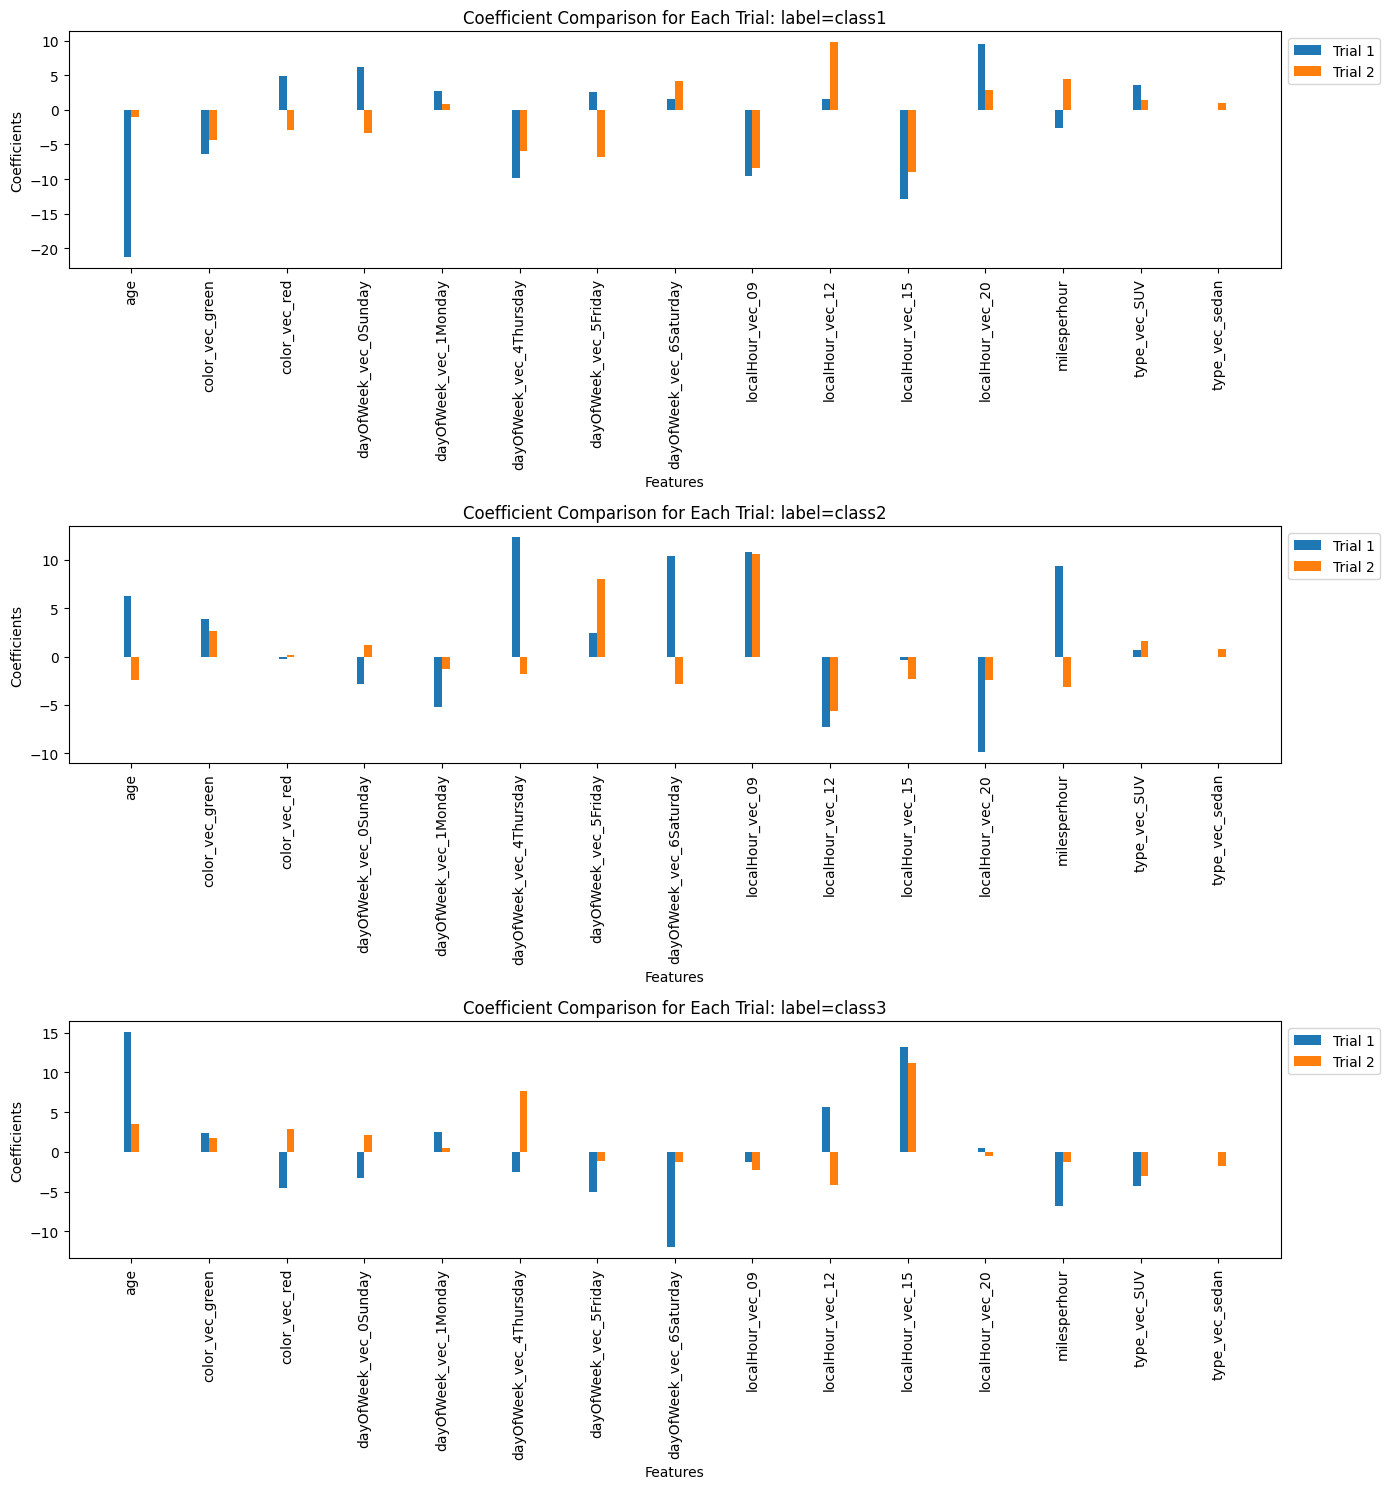

In [68]:
import matplotlib.pyplot as plt

labels = [f"label={label}" for label in unique_columnb_values]

# Create a figure with subplots
fig, axes = plt.subplots(len(labels), 1, figsize=(14, len(labels) * 5))

# Plot each label's coefficients
for idx, label in enumerate(labels):
    ax = axes[idx]
    for i, df in enumerate(coeff_dfs):
        width = 0.1  # Width of the bars
        x = range(len(df))  # X locations for the groups
        ax.bar([p + width*i for p in x], df.sort_values(by="Feature_alias")[label], width=width, label=f'Trial {i+1}')
    
    # Add titles and labels
    ax.set_title(f'Coefficient Comparison for Each Trial: {label}')
    ax.set_xlabel('Features')
    ax.set_ylabel('Coefficients')
    ax.set_xticks([p + width*(len(coeff_dfs)/2 - 0.5) for p in x])
    ax.set_xticklabels(df.sort_values(by="Feature_alias")['Feature_alias'], rotation=90)

    # set xtickslabels only on the last plot
    # if idx < len(labels) - 1:
    #     ax.set_xticklabels([])
    # else:
    #     ax.set_xticklabels(df['Feature_alias'], rotation=90)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Save the plot to a file
plt.savefig('coefficients_comparison.png')

## evaluate

In [202]:
# Initialize evaluators for all models
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label_index", metricName="f1")

In [203]:
# Evaluating the Logistic Regression Model
lr_predictions = lr_model.transform(transformed_test_data_lr_nb)
lr_accuracy = evaluator_accuracy.evaluate(lr_predictions)
lr_precision = evaluator_precision.evaluate(lr_predictions)
lr_recall = evaluator_recall.evaluate(lr_predictions)
lr_f1 = evaluator_f1.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Logistic Regression Precision: {lr_precision}")
print(f"Logistic Regression Recall: {lr_recall}")
print(f"Logistic Regression F1 Score: {lr_f1}")

24/07/28 02:20:37 ERROR Executor: Exception in task 5.0 in stage 1116.0 (TID 3159)
org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (StringIndexerModel$$Lambda$4263/0x0000000801421840: (string) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iter

Py4JJavaError: An error occurred while calling o9632.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 1116.0 failed 1 times, most recent failure: Lost task 5.0 in stage 1116.0 (TID 3159) (192.168.11.11 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (StringIndexerModel$$Lambda$4263/0x0000000801421840: (string) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:197)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Unseen label: 9. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:406)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2790)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2726)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2725)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2725)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1211)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1211)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1211)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2989)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2928)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2917)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:976)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1022)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:408)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1021)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:408)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass$lzycompute(MulticlassMetrics.scala:78)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass(MulticlassMetrics.scala:76)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.accuracy$lzycompute(MulticlassMetrics.scala:188)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.accuracy(MulticlassMetrics.scala:188)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:153)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (StringIndexerModel$$Lambda$4263/0x0000000801421840: (string) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:197)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Unseen label: 9. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:406)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 20 more


In [ ]:
prediction_to_label = dict(zip(range(len(model_lr_nb.stages[0].labels)), model_lr_nb.stages[0].labels))
prediction_to_label

df['pred_label'] = df['label'].map(prediction_label)

In [ ]:
tmp = top5_df.reset_index().rename(columns={"index": "prediction"})
tmp['prediction'] = tmp.prediction.astype(float)
lr_predictions = spark.createDataFrame(tmp)

In [ ]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def translate(mapping):
    def translate_(col):
        return mapping.get(col)
    return udf(translate_, StringType())

lr_predictions.withColumn("pred_label", translate(prediction_to_label)("prediction"))
lr_predictions.show()